## Exploración de datos: Popularidad de canciones Spotify

Este notebook comprende la exploración y preparación de los datos a ser utilizados en la construcción de un modelo de predicción de popularidad de canciones y es parte del proyecto 1 del curso de Machine Learning y Procesamiento de Lenguaje Natural de la Maestría en Inteligencia Analítica de Datos (MIAD)


#### Diccionario de Datos

| Campo              | Descripción                                                                                                                                                                                                                                                                     |
|--------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| track_id           | El ID único de la pista en Spotify.                                                                                                                                                                                                                                              |
| artists            | Los nombres de los artistas que interpretaron la pista. Si hay más de un artista, están separados por un punto y coma (;).                                                                                                                                                         |
| album_name         | El nombre del álbum en el que aparece la pista.                                                                                                                                                                                                                                 |
| track_name         | El nombre de la pista.                                                                                                                                                                                                                                                           |
| popularity         | La popularidad de la pista, un valor entre 0 y 100, donde 100 es la más popular. La popularidad se calcula por un algoritmo basado en el número total de reproducciones y la reciente actividad de estas reproducciones.                                                     |
| duration_ms        | La duración de la pista en milisegundos.                                                                                                                                                                                                                                         |
| explicit           | Indica si la pista tiene letras explícitas (true = sí; false = no o desconocido).                                                                                                                                                                                                |
| danceability       | Describe cuán adecuada es la pista para bailar, basada en una combinación de elementos musicales como tempo, estabilidad del ritmo, fuerza del beat y regularidad general. Un valor de 0.0 es menos bailable y 1.0 es totalmente bailable.                                    |
| energy             | Un valor entre 0.0 y 1.0 que representa la intensidad y actividad perceptual de la pista. Las pistas más enérgicas suelen ser rápidas, ruidosas y activas, como el death metal.                                                                                             |
| key                | La tonalidad en la que se encuentra la pista. Los enteros corresponden a notas usando la notación estándar de Clases de Tonos (por ejemplo, 0 = C, 1 = C♯/D♭, 2 = D, etc.). Si no se detecta tonalidad, el valor es -1.                                                     |
| loudness           | La sonoridad general de la pista en decibelios (dB).                                                                                                                                                                                                                           |
| mode               | Indica la modalidad (mayor o menor) de la pista. 1 representa mayor, y 0 representa menor.                                                                                                                                                                                       |
| speechiness        | Detecta la presencia de palabras habladas en la pista. Valores cercanos a 1.0 indican que la pista es completamente hablada, como en los programas de radio o libros hablados. Valores entre 0.33 y 0.66 sugieren una mezcla de música y habla.                          |
| acousticness       | Una medida de confianza de 0.0 a 1.0 de si la pista es acústica. 1.0 indica alta confianza en que la pista es acústica.                                                                                                                                                          |
| instrumentalness   | Predice si una pista no contiene voces. Los valores cercanos a 1.0 indican una mayor probabilidad de que la pista sea instrumental.                                                                                                                                               |
| liveness           | Detecta la presencia de una audiencia en la grabación. Los valores altos de liveness indican una mayor probabilidad de que la pista sea grabada en vivo.                                                                                                                      |
| valence            | Una medida de 0.0 a 1.0 que describe la positividad musical de la pista. Las pistas con alto valence suenan más positivas (alegres, eufóricas), mientras que las de bajo valence tienden a sonar más negativas (triste, deprimida).                                         |
| tempo              | El tempo estimado de la pista
| time_signature     | Una firma de tiempo estimada, que indica cuántos tiempos hay en cada compás. Los valores varían entre 3 y 7, indicando firmas de tiempo como 3/4, 4/4, hasta 7/4.
| track_genre         | El género musical al que pertenece la pista.

#### 0 - Importación de librerías y definición de funciones

In [1]:
# Librerias
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, KFold, cross_validate, cross_val_predict, cross_val_score, StratifiedKFold, RepeatedStratifiedKFold

#

In [2]:
# plot histogramas
import matplotlib.pyplot as plt
import seaborn as sns

# plot histogramas
def plot_histograms(dataframe):
    columns = dataframe.columns
    num_cols = len(columns)
    num_rows = (num_cols // 2) + (num_cols % 4 > 0)

    fig, axes = plt.subplots(num_rows, 2, figsize=(12, 4 * num_rows))
    fig.tight_layout(pad=3.0)
    plt.subplots_adjust(hspace=0.3)
    axes = axes.flatten()

    for i, column in enumerate(columns):
        ax = axes[i]
        sns.histplot(dataframe[column], ax=ax)
        ax.set_title(f'Histogram of {column}')

        # Calculate the value counts for each category in the column
        value_counts = dataframe[column].value_counts()
        total_count = len(dataframe[column])

        # Sort and select the top 5 values
        top_5 = value_counts.head(5)

        # Annotate the top 5 bars with their percentage
        for val, count in top_5.items():
            percentage = (count / total_count) * 100
            #ax.annotate(f'{percentage:.1f}%',
             #           xy=(val, count),
              #          xytext=(0, 2),  # Offset text slightly above the bar
               #         textcoords='offset points',
                #        ha='center',
                 #       color='black')

    for i in range(num_cols, num_rows * 2):
        fig.delaxes(axes[i])
    plt.show()

def describe_categorical_variables(data):
    # Incluye columnas de tipo 'object' y 'bool'
    categorical_cols = data.select_dtypes(include=['object', 'bool']).columns

    # Creamos el DataFrame para estadísticas categóricas
    categorical_stats = pd.DataFrame(index=categorical_cols, columns=['Unique Values', 'Count', 'Top_Frequency', 'Top'])

    for col in categorical_cols:
        unique_values = data[col].unique()
        unique_count = len(unique_values)
        top_value = data[col].mode().iloc[0]
        top_freq = data[col].value_counts().iloc[0] / len(data)
        categorical_stats.loc[col] = [unique_values, unique_count, top_freq, top_value]

    return categorical_stats


In [3]:
def plot_top10(dataframe):
    columns = dataframe.columns
    num_cols = len(columns)
    num_rows = (num_cols // 2) + (num_cols % 2 > 0)

    fig, axes = plt.subplots(num_rows, 2, figsize=(12, 4 * num_rows))
    fig.tight_layout(pad=3.0)
    plt.subplots_adjust(hspace=0.3)
    axes = axes.flatten()

    for i, column in enumerate(columns):
        ax = axes[i]

        # Calculate the value counts for each category in the column and select the top 10
        value_counts = dataframe[column].value_counts().head(10)
        top_10_categories = value_counts.index

        # Filter the dataframe to include only the top 10 categories
        filtered_data = dataframe[column][dataframe[column].isin(top_10_categories)]

        # Plot the filtered data with the counts for each of the top 10 categories
        sns.histplot(filtered_data, ax=ax, discrete=True)

        # Set the title with the column name
        ax.set_title(f'Histogram of {column} (Top 10 Categories)')

        # Rotate x-axis labels for better readability
        ax.tick_params(axis='x', rotation=45)

        # Annotate the top 10 bars with their percentage
        total_count = len(dataframe[column])
        for val, count in value_counts.items():
            percentage = (count / total_count) * 100
            ax.annotate(f'{percentage:.1f}%',
                        xy=(val, count),
                        xytext=(0, 2),  # Offset text slightly above the bar
                        textcoords='offset points',
                        ha='center',
                        color='black')

    # Remove any extra axes if there are more subplots than columns
    for i in range(num_cols, num_rows * 2):
        fig.delaxes(axes[i])
    plt.show()

In [4]:
def plot_hist(variable):
    plt.figure(figsize=(12, 5))
    plt.tight_layout()
    ax = sns.histplot(x=variable)
    value_counts = variable.value_counts()
    # Annotate each bar with its count
    for p in ax.patches:
        count = value_counts.get(p.get_x(),"")
        #ax.annotate(f'{p.get_height()}\n{count}',
         #       (p.get_x() + p.get_width() / 2., p.get_height()),
          #      ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    # Rotar las leyendas del eje x
    ax.set_xticks(ax.get_xticks()) # added ABC
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
    plt.show()

In [5]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

def boxplot_interactivo_numericas(df, target_continuous):
    # Seleccionar variables numéricas, excluyendo la variable target
    num_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    if target_continuous in num_columns:
        num_columns.remove(target_continuous)

    dropdown = widgets.Dropdown(
        options=num_columns,
        description='Variable numérica:',
        value=num_columns[0]
    )

    out = widgets.Output()

    def on_change(change):
        if change['type'] == 'change' and change['name'] == 'value':
            out.clear_output(wait=True)
            with out:
                plt.figure(figsize=(10, 5))
                sns.scatterplot(x=df[change['new']], y=df[target_continuous])
                plt.title(f'{target_continuous} vs {change["new"]}')
                plt.xlabel(change["new"])
                plt.ylabel(target_continuous)
                plt.tight_layout()
                plt.show()

    dropdown.observe(on_change)
    display(dropdown, out)

    # Inicialización con el valor por defecto
    on_change({'type': 'change', 'name': 'value', 'new': dropdown.value})

In [6]:

def boxplots_top10_categoricas(df, target_continuous):
    #cat_columns = df.select_dtypes(include=['object', 'bool']).columns
    cat_columns = df.select_dtypes(include=['object']).columns
    num_cols = len(cat_columns)
    num_rows = (num_cols // 2) + (num_cols % 2 > 0)

    fig, axes = plt.subplots(num_rows, 2, figsize=(15, 4 * num_rows))
    fig.tight_layout(pad=3.0)
    plt.subplots_adjust(hspace=0.4)
    axes = axes.flatten()

    for i, column in enumerate(cat_columns):
        ax = axes[i]

        # Obtener top 10 categorías más frecuentes
        top_10 = df[column].value_counts().head(10).index
        filtered_df = df[df[column].isin(top_10)]

        # Graficar boxplot
        sns.boxplot(x=filtered_df[column], y=filtered_df[target_continuous], ax=ax)
        ax.set_title(f'{target_continuous} vs {column} (Top 10)')
        ax.set_xlabel(column)
        ax.set_ylabel(target_continuous)
        ax.tick_params(axis='x', rotation=25)

    # Eliminar ejes vacíos si hay menos columnas que subplots
    for j in range(num_cols, num_rows * 2):
        fig.delaxes(axes[j])

    plt.show()

### 1 - Carga y Analisis Preliminar de los datos


In [7]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2025/main/datasets/dataTrain_Spotify.csv')
dataTesting = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2025/main/datasets/dataTest_Spotify.csv', index_col=0)

In [8]:
# Visualización datos de entrenamiento
dataTraining.head()

,Unnamed: 0,track_id,artists,album_name,track_name,duration_ms,explicit,danceability,energy,key,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,popularity
0,0,7hUhmkALyQ8SX9mJs5XI3D,Love and Rockets,Love and Rockets,Motorcycle,211533,False,0.305,0.8490,9,...,1,0.0549,0.000058,0.056700,0.4640,0.3200,141.793,4,goth,22
1,1,5x59U89ZnjZXuNAAlc8X1u,Filippa Giordano,Filippa Giordano,"Addio del passato - From ""La traviata""",196000,False,0.287,0.1900,7,...,0,0.0370,0.930000,0.000356,0.0834,0.1330,83.685,4,opera,22
2,2,70Vng5jLzoJLmeLu3ayBQq,Susumu Yokota,Symbol,Purple Rose Minuet,216506,False,0.583,0.5090,1,...,1,0.0362,0.777000,0.202000,0.1150,0.5440,90.459,3,idm,37
3,3,1cRfzLJapgtwJ61xszs37b,Franz Liszt;YUNDI,Relajación y siestas,"Liebeslied (Widmung), S. 566",218346,False,0.163,0.0368,8,...,1,0.0472,0.991000,0.899000,0.1070,0.0387,69.442,3,classical,0
4,4,47d5lYjbiMy0EdMRV8lRou,Scooter,Scooter Forever,The Darkside,173160,False,0.647,0.9210,2,...,1,0.1850,0.000939,0.371000,0.1310,0.1710,137.981,4,techno,27


In [9]:
# Visualización datos de test
dataTesting.head(3)

,track_id,artists,album_name,track_name,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,6KwkVtXm8OUp2XffN5k7lY,Hillsong Worship,No Other Name,No Other Name,440247,False,0.369,0.598,7,-6.984,1,0.0304,0.00511,0.00000,0.176,0.0466,148.014,4,world-music
1,2dp5I5MJ8bQQHDoFaNRFtX,Internal Rot,Grieving Birth,Failed Organum,93933,False,0.171,0.997,7,-3.586,1,0.1180,0.00521,0.80100,0.420,0.0294,122.223,4,grindcore
2,5avw06usmFkFrPjX8NxC40,Zhoobin Askarieh;Ali Sasha,Noise A Noise 20.4-1,"Save the Trees, Pt. 1",213578,False,0.173,0.803,9,-10.071,0,0.1440,0.61300,0.00191,0.195,0.0887,75.564,3,iranian


In [10]:
# Resumen de tipo y cantidad de datos por columna:
dataTraining.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79800 entries, 0 to 79799
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        79800 non-null  int64  
 1   track_id          79800 non-null  object 
 2   artists           79800 non-null  object 
 3   album_name        79800 non-null  object 
 4   track_name        79800 non-null  object 
 5   duration_ms       79800 non-null  int64  
 6   explicit          79800 non-null  bool   
 7   danceability      79800 non-null  float64
 8   energy            79800 non-null  float64
 9   key               79800 non-null  int64  
 10  loudness          79800 non-null  float64
 11  mode              79800 non-null  int64  
 12  speechiness       79800 non-null  float64
 13  acousticness      79800 non-null  float64
 14  instrumentalness  79800 non-null  float64
 15  liveness          79800 non-null  float64
 16  valence           79800 non-null  float6

### 2 - Exploración y Preparación de los Datos

In [11]:
# Verificación de existencia de NAs:
dataTraining.isna().sum()

Unnamed: 0          0
track_id            0
artists             0
album_name          0
track_name          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
popularity          0
dtype: int64

In [12]:
# Quitando columnas que no tienen aporte
columns_to_drop = ['track_id', 'Unnamed: 0']
data = dataTraining.drop(columns=columns_to_drop)

In [13]:
# Verificación de existencia de observaciones duplicadas

duplicates = data[data.duplicated()]
duplicate_count = duplicates.shape[0]

print("Observaciones duplicadas:", duplicate_count)

Observaciones duplicadas: 303


In [14]:
# Eliminación de observaciones duplicadas

data = data.drop_duplicates()

print(data.shape)

(79497, 19)


In [15]:
# Creación de una nueva variable que cuenta el numero de artistas en una canción

data.loc[:, 'artist_count'] = data['artists'].str.count(';') + 1

data.tail()

,artists,album_name,track_name,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,popularity,artist_count
79795,Amilcare Ponchielli;Gothenburg Symphony Orches...,"Ballet Highlights - The Nutcracker, Romeo & Ju...",La Gioconda / Act 3: Dance Of The Hours,162613,False,0.554,0.00763,4,-30.566,1,0.0502,0.915,0.00097,0.2210,0.1560,119.502,4,opera,49,3
79796,Sajanka,Time of India,Time of India,240062,False,0.689,0.55400,9,-8.200,1,0.0759,0.091,0.91400,0.0867,0.1630,148.002,4,trance,30,1
79797,Frankie Valli & The Four Seasons,Merry Christmas,I Saw Mommy Kissing Santa Claus,136306,False,0.629,0.56000,0,-11.455,0,0.0523,0.595,0.00000,0.1820,0.8800,118.895,3,soul,0,1
79798,The Mayries,I Will Wait,I Will Wait,216841,False,0.421,0.10700,6,-15.191,1,0.0335,0.948,0.00000,0.0881,0.1180,104.218,4,acoustic,44,1
79799,S N U G;Dyrean,Rainy Nights,Back Then,127200,False,0.565,0.24000,10,-18.678,1,0.0439,0.931,0.91200,0.3790,0.0827,114.930,4,chill,55,2


In [16]:
# Resumen estadístico or columna:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
duration_ms,79497.0,227960.763123,103862.896699,13386.000000,174545.0000,212903.000000,261543.0000,5237295.000
danceability,79497.0,0.567500,0.173033,0.000000,0.4560,0.581000,0.6950,0.985
energy,79497.0,0.642149,0.251049,0.000019,0.4730,0.686000,0.8540,1.000
key,79497.0,5.307131,3.561580,0.000000,2.0000,5.000000,8.0000,11.000
loudness,79497.0,-8.251395,5.022835,-49.307000,-9.9940,-7.006000,-4.9980,4.532
mode,79497.0,0.637747,0.480654,0.000000,0.0000,1.000000,1.0000,1.000
speechiness,79497.0,0.084755,0.105669,0.000000,0.0359,0.049000,0.0845,0.965
acousticness,79497.0,0.314338,0.332046,0.000000,0.0170,0.168000,0.5970,0.996
instrumentalness,79497.0,0.157124,0.310594,0.000000,0.0000,0.000041,0.0503,1.000
liveness,79497.0,0.213395,0.190190,0.000000,0.0979,0.132000,0.2730,1.000


In [17]:
# Tempo 0 es un error en una pista de audio ya que el tempo se refiere a la velocidad de un audio.

data_filtrado = data[data['tempo'] == 0]
print(f"Cantidad de canciones con tempo = 0: {len(data_filtrado)}")

# Son pocas canciones, se dejan en el dataset

Cantidad de canciones con tempo = 0: 99


In [18]:
# Conversión de la columna duracion_ms a minutos para interpretar mejor los datos

#data['duration_min'] = data['duration_ms'] / 60000

In [19]:
# Descripción de la variable minutos
#data['duration_min'].describe().T

In [20]:
#plot_hist(data['duration_min'])

In [21]:
# Separando columnas numéricas de categóricas

columnas_numericas = data.select_dtypes(include=['number']).columns

# Columnas categóricas (incluye object y bool)
columnas_categoricas = data.select_dtypes(include=['object', 'bool']).columns

# También podrías separar los DataFrames si lo prefieres:
data_numericas = data[columnas_numericas]
data_categoricas = data[columnas_categoricas]

print("Columnas numéricas: ",columnas_numericas)

print("Columnas categóricas: ",columnas_categoricas)

Columnas numéricas:  Index(['duration_ms', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature', 'popularity', 'artist_count'],
      dtype='object')
Columnas categóricas:  Index(['artists', 'album_name', 'track_name', 'explicit', 'track_genre'], dtype='object')


#### 2a. Variables Categóricas

In [22]:
# Descripción de variables categoricas:
# cantidad de valores únicos (Count) ,
# valor más frecuente (Top)  y
# frecuencia de dicha observación (Top_Frequency)

describe_categorical_variables(data_categoricas)

,Unique Values,Count,Top_Frequency,Top
artists,"[Love and Rockets, Filippa Giordano, Susumu Yo...",25775,0.00244,The Beatles
album_name,"[Love and Rockets, Filippa Giordano, Symbol, R...",37315,0.001535,Feliz Cumpleaños con Perreo
track_name,"[Motorcycle, Addio del passato - From ""La trav...",55767,0.001447,Run Rudolph Run
explicit,"[False, True]",2,0.914299,False
track_genre,"[goth, opera, idm, classical, techno, pop, aco...",114,0.009271,progressive-house


<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


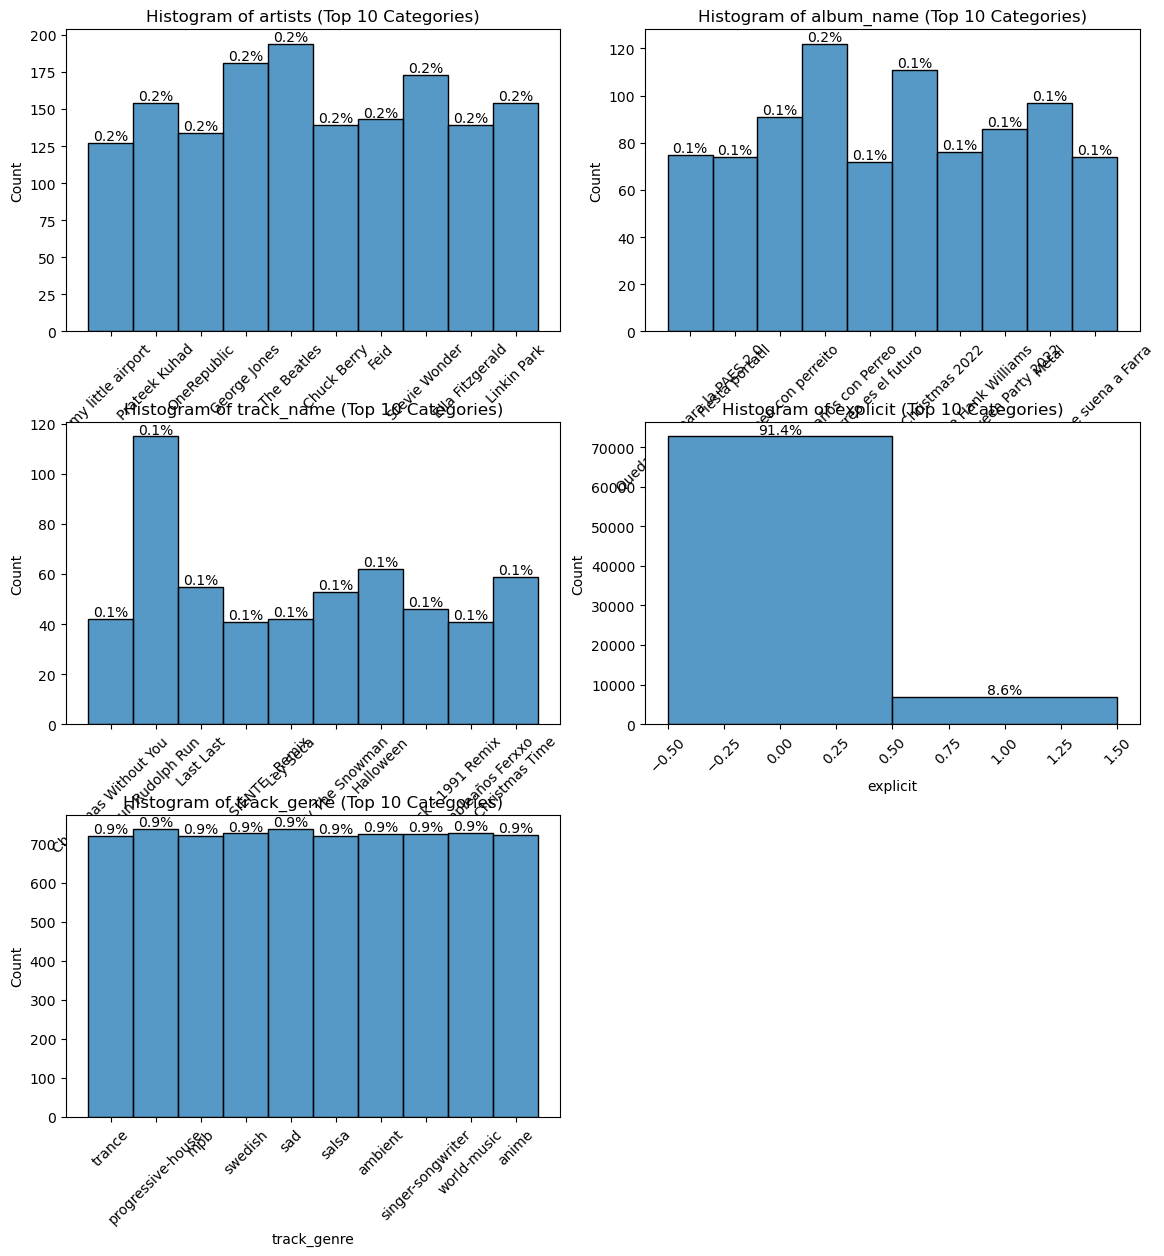

In [23]:
# Graficos de variables categoricas para las top 10 categorías
plot_top10(data_categoricas)

In [24]:
# Observando variable explicit

conteo = data_categoricas['explicit'].value_counts()
porcentajes = data_categoricas['explicit'].value_counts(normalize=True) * 100

resumen = pd.DataFrame({
    'Cantidad': conteo,
    'Porcentaje (%)': porcentajes.round(2)
})

print(resumen)

          Cantidad  Porcentaje (%)
explicit                          
False        72684           91.43
True          6813            8.57


#### 2b. Variables numéricas

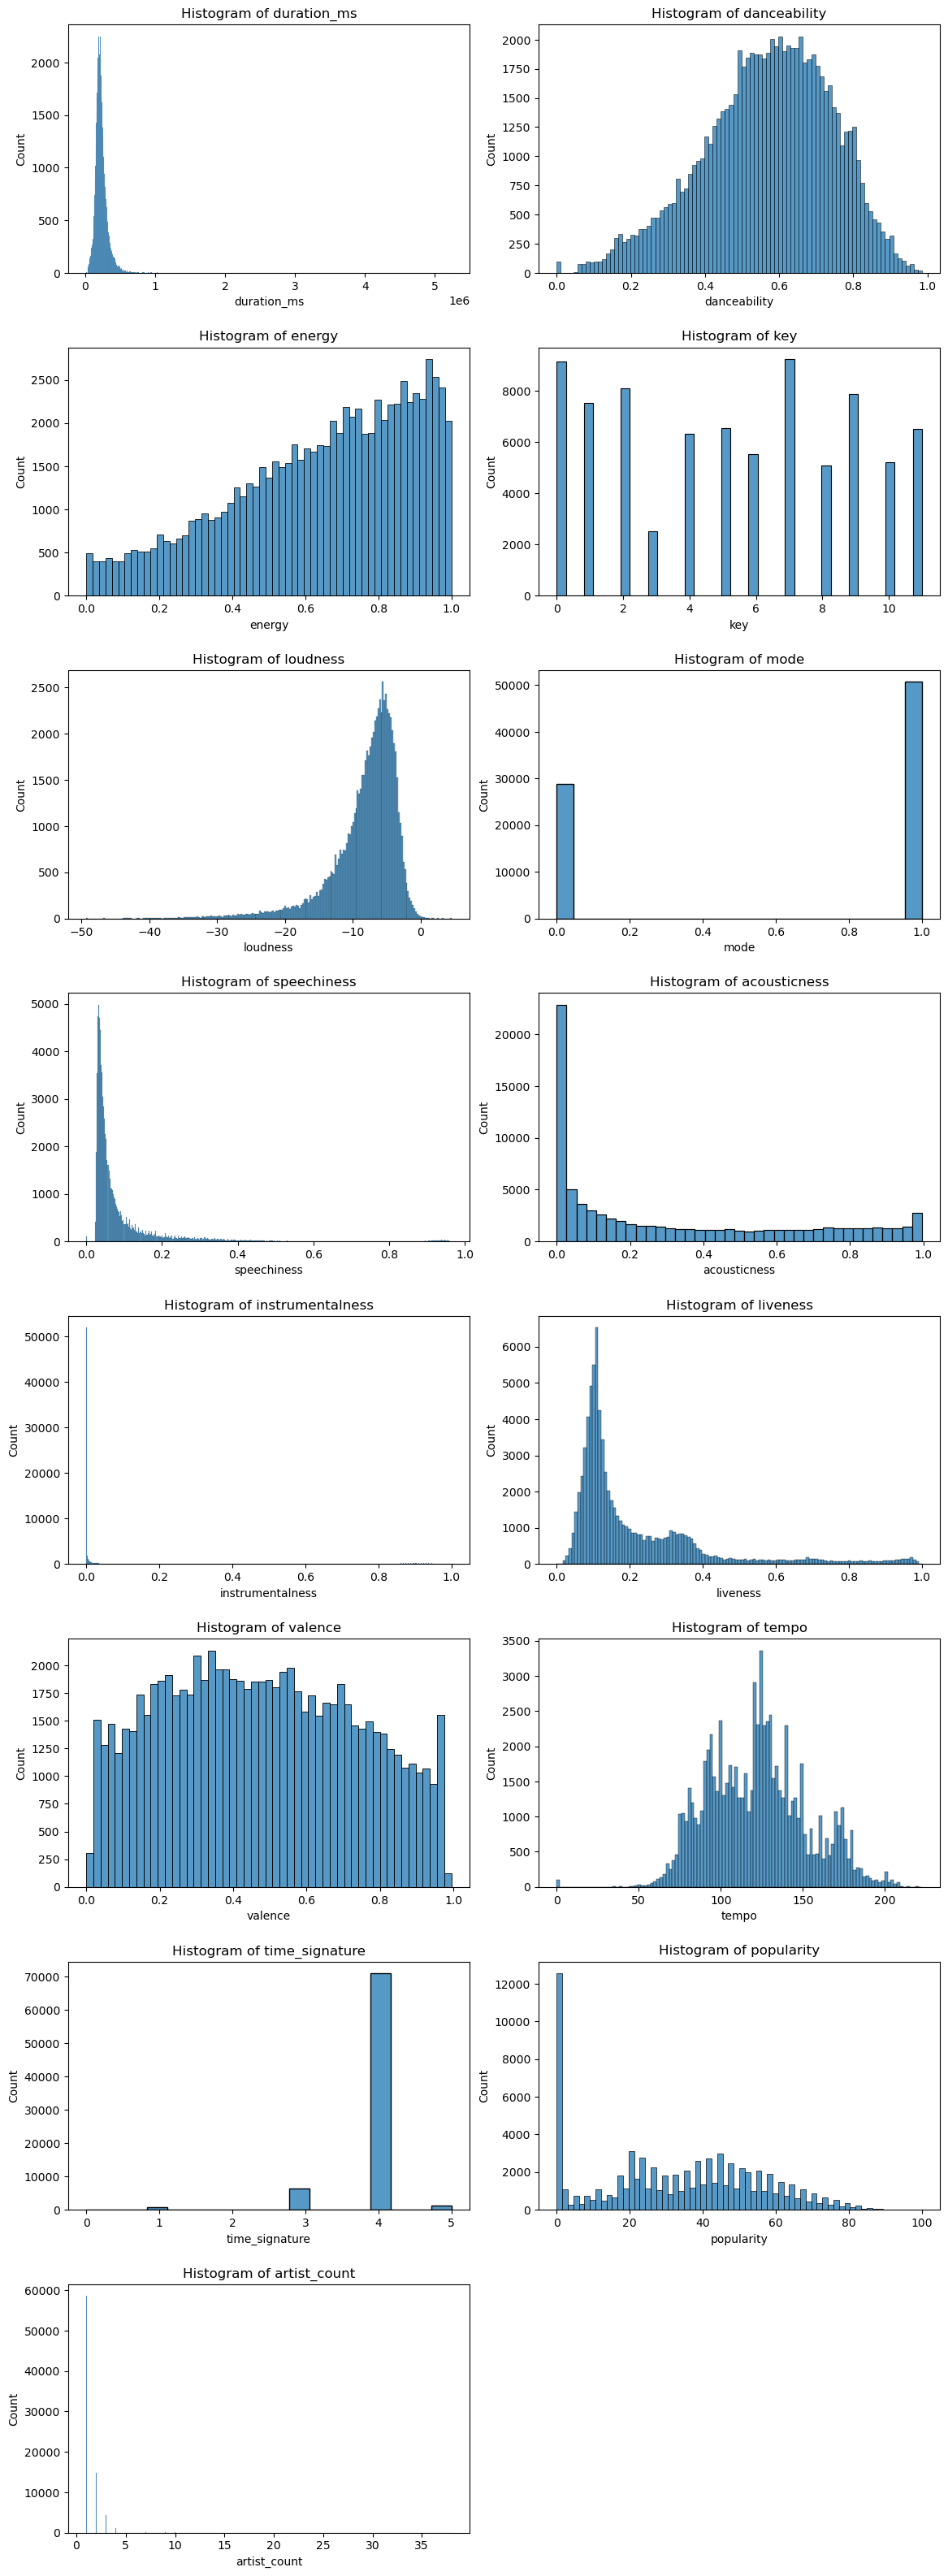

In [25]:
#Observando histogramas de las variables numéricas
plot_histograms(data_numericas)

In [26]:
#Revisión en mayor detalle las observacion con popularidad 0, para determinar si representan canciones o no:

data_copia_0 = data.copy()

# Filtrar observaciones donde popularity == 0
data_pop0 = data_copia_0[data_copia_0['popularity'] == 0]

data_pop0.describe().transpose()

#Se observa que las variables explicativas presentan valores válidos que parecen indicar que si se trata de canciones

,count,mean,std,min,25%,50%,75%,max
duration_ms,11066.0,214148.087656,82011.463326,13386.000000,169293.000000,200461.000000,240413.00000,1937632.000
danceability,11066.0,0.575462,0.178172,0.000000,0.455000,0.594000,0.70900,0.970
energy,11066.0,0.614940,0.255828,0.000036,0.447000,0.669000,0.82500,0.999
key,11066.0,5.321525,3.600347,0.000000,2.000000,6.000000,8.00000,11.000
loudness,11066.0,-8.222582,5.278036,-41.808000,-9.644750,-6.636500,-4.85600,3.156
mode,11066.0,0.659769,0.473808,0.000000,0.000000,1.000000,1.00000,1.000
speechiness,11066.0,0.073877,0.071003,0.000000,0.036200,0.048500,0.07840,0.918
acousticness,11066.0,0.341182,0.347182,0.000000,0.033125,0.177000,0.66000,0.996
instrumentalness,11066.0,0.105506,0.264042,0.000000,0.000000,0.000008,0.00302,0.998
liveness,11066.0,0.186177,0.149521,0.015000,0.094600,0.125000,0.24800,0.985


In [27]:
#data.describe().T

#### 2c. Relación entre variables X numéricas y variable respuesta y

In [28]:
boxplot_interactivo_numericas(data, 'popularity')


Dropdown(description='Variable numérica:', options=('duration_ms', 'danceability', 'energy', 'key', 'loudness'…

Output()

In [51]:
cols = ['duration_ms', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature', 'artist_count', 'popularity']

data_numericas = data_numericas[cols]

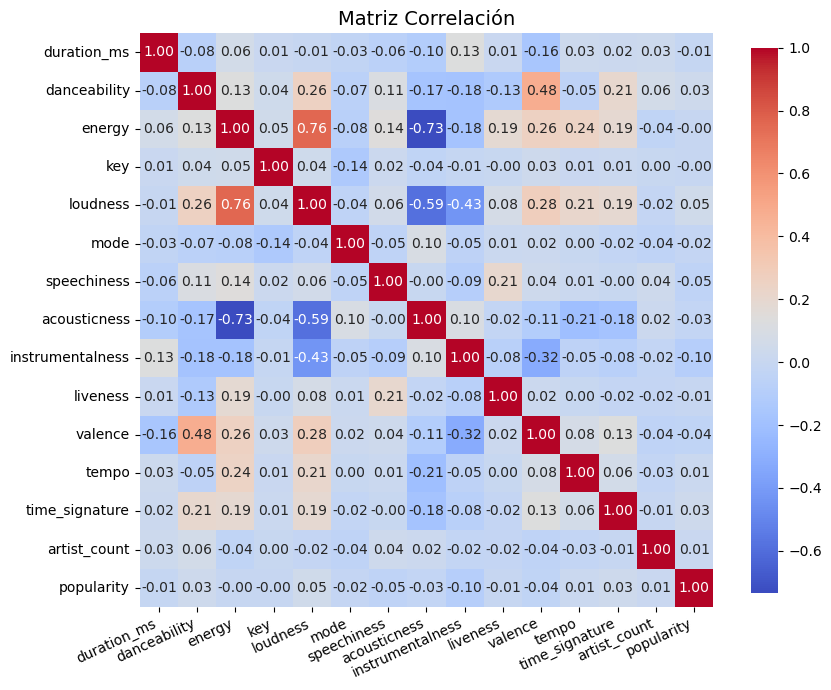

In [52]:
corr_matrix=data_numericas.corr()
plt.figure(figsize=(9,7))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .95})
plt.title(f"Matriz Correlación", fontsize=14)
plt.xticks(rotation=25, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#### 2d. Relación entre variables X categóricas y variable respuesta y

In [30]:
# Seleccionar subset para boxplot

boxplot_popularity = ['artists', 'album_name', 'track_name', 'explicit', 'track_genre', 'popularity']
data_reducida = data[boxplot_popularity]

data_reducida.head()


,artists,album_name,track_name,explicit,track_genre,popularity
0,Love and Rockets,Love and Rockets,Motorcycle,False,goth,22
1,Filippa Giordano,Filippa Giordano,"Addio del passato - From ""La traviata""",False,opera,22
2,Susumu Yokota,Symbol,Purple Rose Minuet,False,idm,37
3,Franz Liszt;YUNDI,Relajación y siestas,"Liebeslied (Widmung), S. 566",False,classical,0
4,Scooter,Scooter Forever,The Darkside,False,techno,27


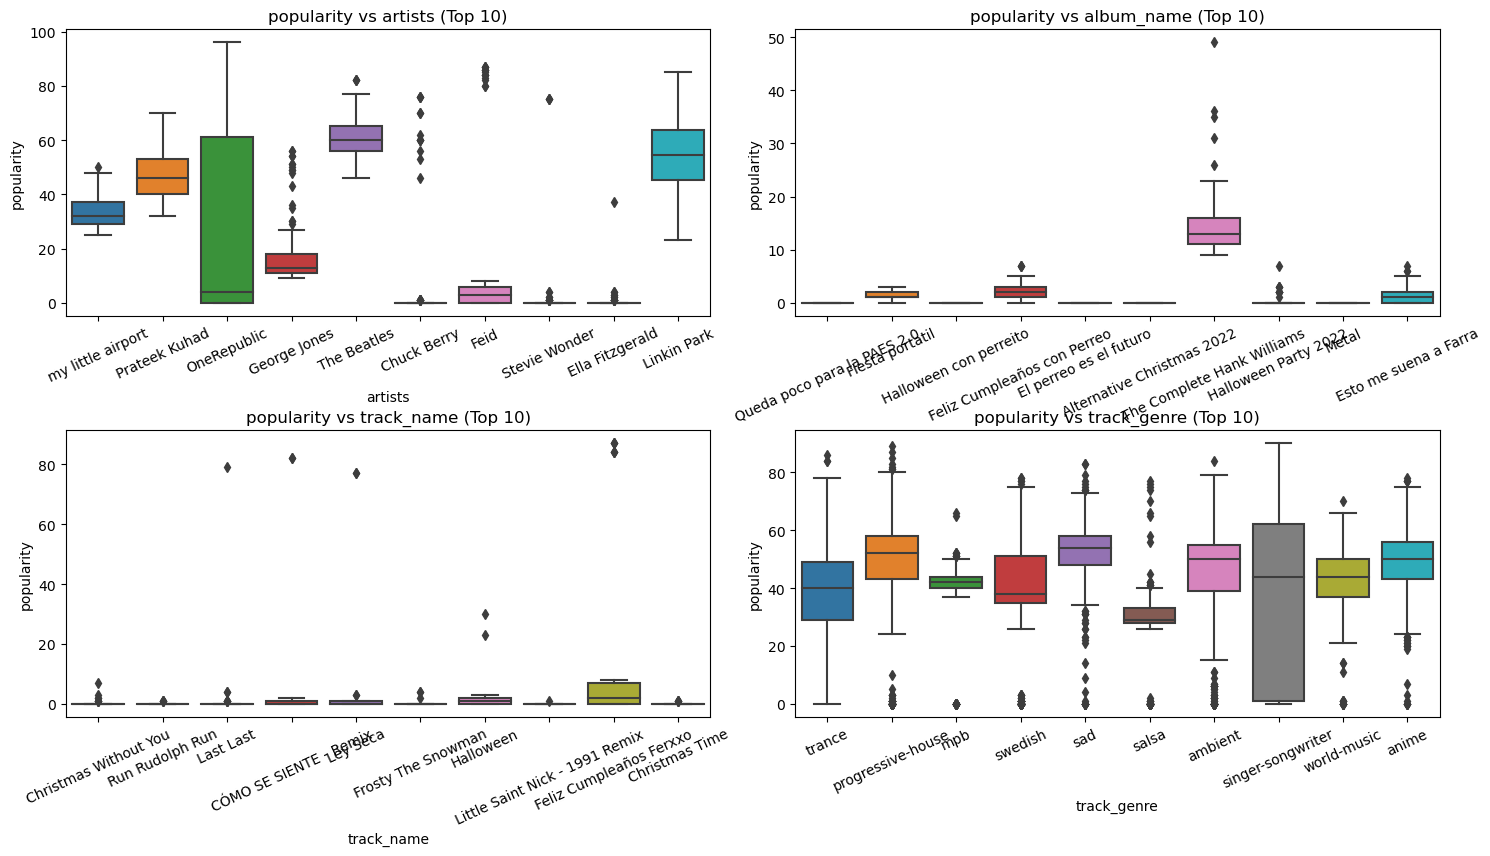

In [31]:
# Ejecutar la función con la data reducida

boxplots_top10_categoricas(data_reducida,'popularity')

### 3 - Exportar datos para XGBoost
Características: datos sin escalar ni codificar

In [32]:
data.shape

(79497, 20)

In [33]:
data.head()

,artists,album_name,track_name,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,popularity,artist_count
0,Love and Rockets,Love and Rockets,Motorcycle,211533,False,0.305,0.8490,9,-10.795,1,0.0549,0.000058,0.056700,0.4640,0.3200,141.793,4,goth,22,1
1,Filippa Giordano,Filippa Giordano,"Addio del passato - From ""La traviata""",196000,False,0.287,0.1900,7,-12.030,0,0.0370,0.930000,0.000356,0.0834,0.1330,83.685,4,opera,22,1
2,Susumu Yokota,Symbol,Purple Rose Minuet,216506,False,0.583,0.5090,1,-9.661,1,0.0362,0.777000,0.202000,0.1150,0.5440,90.459,3,idm,37,1
3,Franz Liszt;YUNDI,Relajación y siestas,"Liebeslied (Widmung), S. 566",218346,False,0.163,0.0368,8,-23.149,1,0.0472,0.991000,0.899000,0.1070,0.0387,69.442,3,classical,0,2
4,Scooter,Scooter Forever,The Darkside,173160,False,0.647,0.9210,2,-7.294,1,0.1850,0.000939,0.371000,0.1310,0.1710,137.981,4,techno,27,1


In [36]:
# Separación de variables predictoras (X) y variable de interés (y)
y_xgboost = data['popularity']
X_xgboost = data.drop(['popularity'], axis=1)

In [37]:
#X_test_xgboost.head()

In [38]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train_xgboost, X_test_xgboost, y_train_xgboost, y_test_xgboost = train_test_split(X_xgboost, y_xgboost, test_size=0.15, random_state=42)

In [39]:
X_xgboost.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79497 entries, 0 to 79799
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artists           79497 non-null  object 
 1   album_name        79497 non-null  object 
 2   track_name        79497 non-null  object 
 3   duration_ms       79497 non-null  int64  
 4   explicit          79497 non-null  bool   
 5   danceability      79497 non-null  float64
 6   energy            79497 non-null  float64
 7   key               79497 non-null  int64  
 8   loudness          79497 non-null  float64
 9   mode              79497 non-null  int64  
 10  speechiness       79497 non-null  float64
 11  acousticness      79497 non-null  float64
 12  instrumentalness  79497 non-null  float64
 13  liveness          79497 non-null  float64
 14  valence           79497 non-null  float64
 15  tempo             79497 non-null  float64
 16  time_signature    79497 non-null  int64  
 17

In [41]:
# exportar datos
X_train_xgboost.to_csv("datos/X_train_xgboost.csv", index=False)
X_test_xgboost.to_csv("datos/X_test_xgboost.csv", index=False)
y_train_xgboost.to_csv("datos/y_train_xgboost.csv", index=False)
y_test_xgboost.to_csv("datos/y_test_xgboost.csv", index=False)


### 4 - Exportar datos para Random forecast
Características: sólo variables numéricas y explicit codificada

In [42]:
data.shape

(79497, 20)

In [44]:
# Separación de variables predictoras (X) y variable de interés (y)
y_rf = data['popularity']
X_rf = data.drop(['popularity','artists', 'album_name','track_name','track_genre'], axis=1)

In [45]:
X_rf.dtypes

duration_ms           int64
explicit               bool
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
artist_count          int64
dtype: object

In [46]:
# Codificacion Variables Booleanas
def encode_bool(X):
    X_encoded = X.copy()
    X_encoded = X_encoded.applymap(lambda x: int(x) if isinstance(x, bool) else x)
    return X_encoded

X_rf_enc = encode_bool(X_rf)


In [47]:
X_rf_enc.head()

,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,artist_count
0,211533,0,0.305,0.8490,9,-10.795,1,0.0549,0.000058,0.056700,0.4640,0.3200,141.793,4,1
1,196000,0,0.287,0.1900,7,-12.030,0,0.0370,0.930000,0.000356,0.0834,0.1330,83.685,4,1
2,216506,0,0.583,0.5090,1,-9.661,1,0.0362,0.777000,0.202000,0.1150,0.5440,90.459,3,1
3,218346,0,0.163,0.0368,8,-23.149,1,0.0472,0.991000,0.899000,0.1070,0.0387,69.442,3,2
4,173160,0,0.647,0.9210,2,-7.294,1,0.1850,0.000939,0.371000,0.1310,0.1710,137.981,4,1


In [48]:
# Separación de datos en set de entrenamiento y test
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf_enc, y_rf, test_size=0.15, random_state=42)

In [49]:
# exportar datos
X_train_rf.to_csv("datos/X_train_rf.csv", index=False)
X_test_rf.to_csv("datos/X_test_rf.csv", index=False)
y_train_rf.to_csv("datos/y_train_rf.csv", index=False)
y_test_rf.to_csv("datos/y_test_rf.csv", index=False)

### **Conclusión sobre la preparación de los datos**:
Para este ejercicio contamos con el set de datos de entrenamiento dataTrain_Spotify.csv. El mismo contiene 21 variables y 79800 observaciones, 6 variables son categóricas y 15 variables son numéricas.  
Variables categóricas: track_id, artists, album_name, track_name, explicit y track_genre.  
Variables numéricas: unnamed: 0, duration_ms, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, time_signature, popularity.  
La variable respuesta que intentaremos predecir a través de un modelo es "popularity" que refiere a la popularidad de la canción.

##### **Procesamiento de datos realizados:**   
A nivel de variables: procedimos a eliminar las columnas unnamed: 0 y track_id por tratartse de variables identificativas que no aportan ningún valor.
También creamos una nueva columna para contar la cantidad de artistas en cada track.  

A nivel de observaciones: no se observan valores nulos ni "na" en las variables. Identificamos 99 observaciones donde la variable tempo es 0, lo que podría ser un error pero por el bajo número de casos no tomamos ninguna medida al respecto. También se observan valores máximos muy elevados en algunas variables lo que indica la presencia de outliers pero tampoco se aplica un tratamiento de los mismos ya que los árboles de decisión se caracterizan por un buen manejo de los mismos.
Por último se identifican y eliminan 303 observaciones duplicadas.

Al finalizar estos ajustes el data set de entrenamiento cuenta con 19 variables y 79497 observaciones.

##### **Analísis gráfico y estadístico de las variables:**     


###### <u>Variable respuesta "popularity":</u>  
Al observar los datos estadísticos de esta variable podemos observar como el 75% de las observaciones se encuentra por debajo de 50 de popularidad, esto también se puede observar al ver el histograma de la variable donde vemos una mayor concentración de datos hacia los valores bajos de popularidad.
También se observan una gran cantidad de datos con popularidad = 0 pero al analizarlos con mayor detenimiento logramos determinar que se tratan de canciones y entendimos que no se requiere ningun ajuste.
Esta situación de la variable y presenta un desbalanceo que puede tener un impacto en el entrenamiento de los modelos ya que puede que los árboles aprendan más sobre la predicción de casos de popularidad baja y no aprenda a predecir satisfactoriamente los de popularidad alta.

Por ese motivo se recomienda gestionar el desbalanceo al entrenar los modelos utilizando la opción de atribuir distintos pesos a las observaciones. De esta manera podemos indicarle al modelo que le de mayor peso a las observaciones con menor popularidad.

###### <u>Variables explicativas numéricas:</u>  

Las variables numéricas presenta distintas distribuciónes que se pueden observar en los gráficos incluidos en el notebook (link a github), algunas observaciones:  

**'duration_ms'** promedio 227960 milisegundos que equivalen a 3.79 minutos.  

**'danceability'** promedio 0,56: medianamente bailable.  

**'energy'** promedio 0.64: mayor presencia de pistas enérgicas.  

**'key'** es una variable numérica que se comporta cómo categórica porque se refiere a la tonalidad, en el histograma se puede observar una mayor cantidad de datos con key 0 (C (Do)), 1 	(C♯ / D♭), 2 (D (Re)), 7 (	G (Sol)).  

**'loudness'** se concentra entre -10 y 0. 0 dB represent el volumen máximo digital y en geneal -5 dB	se considera un valor "Muy fuerte" presente en el pop por ejemplo, mientras que -20 se considera "Suave" presente en música clásica o  acústica.   

**'mode'** puede ser 0 si es modalidad menor o 1 si es modalidad mayor y hay mayor concentración de datos en 1.  

**'speechiness'** promedio 0.08 indica que hay una baja presencia de pistas habladas.  

**'acousticness'** promedio 0.31 lo cual indica una baja presencia de canciones acústicas.  

**'instrumentalness'** promedio 0.15 también indica en este caso una baja presencia de canciones instrumentales.

**'liveness'** promedio 0.21 nos indica que hay baja presencia de pistas grabadas en vivo.  

**'valence'** promedio 0.47 describe una positividad musical media en los datos.

**'tempo'** promedio 122.09 indica que la velocidad de las pistas es rítmica, ni muy lenta ni muy rápida.  

**time_signature** promedio 3.9 también en este caso es una variable numérica que se comporta cómo categórica y la mayoría de las observación se encuentra en 4 compases, que es lo mas común en pistas populares y de rock.   

**artist_count** promedio 1.38 indica que la mayoría de las pistas corresponden a un solo artista.

###### <u>Variables explicativas categóricas:</u>

La mayoría de las variables categóricas presenta un gran número de valores únicos:

**track_genre**  114

**track_name** 55767

**artists** 25775

**album_name** 37315

**explicit** es booleana, true indica letras explicitas y false lo contrario, el 91% de los datos corresponden a false.                        

Las variables categóricas **track_genre**, **track_name**, **artists** y
**album_name** no resultan otimas para codificar ya que al tener tantos valores unicos el data set presentaría una gran dimensionalidad. Como XGBoost permite el manejo de variables categóricas pero Random Forest no lo permite el resultado de este notebook es set de datos distintos para Random Forest que para XgBoost.

Random Forest: se excluyen estas variables mencionadas, se codifica "explicit y se separan en Train y test utilizando un 15% de los datos para test:

X_train_rf.csv
X_test_rf.csv
y_train_rf.csv
y_test_rf.csv

XGBoost: se utilizan todas las variables sin codificar ni escalar:

X_train_xgboost.csv
X_test_xgboost.csv
y_train_xgboost.csv
y_test_xgboost.csv

Previo a la calibración y entrenamiento de los modelos deberemos asegurarnos de que las variables de tipo object se conviertan a Categoricals para poder correr XGBoost con enable_categorical=True